# MARS EXPRESS - Dynamical Model Error
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
Within this example, we will go beyond the earlier introduced basic steps of setting up an orbit estimation routine. In particular, using several orbits of the Mars Express (MEX) spacecraft around the Red Planet, we will introduce different new types of observables, observation constraints, and finally focus on how to apply different dynamical models to the simulation of observations and the estimation, respectively. Since no further explanation with respect to already introduced functionalities will be given in this example, the reader is advised - if not already done so - to first browse to the previous examples.

Using different dynamical models for the simulation of observations and the subsequent estimation comes in handy when trying to emulate the effect an imperfect dynamical model will have on the estimation of selected parameters based on real-world data. In detail, while trivially, real-world data stems from a perfectly 'modelled' environment, the estimator will always be subject to modelling shortcomings. By using a slightly less advanced model for the estimation than for the simulation of observations, we are able to artificially mock this and gain insights into the behaviour and sensitivity of the found solution to modelling imperfections.

## Import Statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`. Moreover, we import `os` to be able to tell our system where it can find the downloaded SPICE kernel for Mars Express.

Again, mainly (new) functionalities of the `estimation`, `estimation_setup`, and `observations` modules of the imported `tudatpy`packages will be used and demonstrated within this example.


In [1]:
# Load required standard modules
import os
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation import create_dynamics_simulator
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion

# Retrieve current directory
current_directory = os.getcwd()

## Simulation Settings
After having defined the general configuration of our simulation (i.e. importing required `SPICE` kernels, defining start and end epoch of the simulation) we will create the main celestial bodies involved in the simulation (mainly Mars, its two moons, the two neighbouring planets, and the Sun), the spacecraft itself, and its environment interface.

In [2]:
# Load standard spice kernels as well as the one describing the orbit of Mars Express
spice.load_standard_kernels()
spice.load_kernel(current_directory + "/ORMM_T19_031222180906_00052.BSP")

# Set simulation start (January 1st, 2004 - 00:00) and end epochs (January 11th, 2004 - 00:00)
simulation_start_epoch = DateTime(2004, 1,  1).epoch()
simulation_end_epoch   = DateTime(2004, 1, 11).epoch()

### CELESTIAL BODIES ###
# Create default body settings for "Mars", "Phobos", "Deimos", "Sun", "Jupiter", "Earth"
bodies_to_create = ["Mars", "Phobos", "Deimos", "Sun", "Jupiter", "Earth"]

# Create default body settings for bodies_to_create, with "Mars"/"J2000" as the global frame origin and orientation
global_frame_origin = "Mars"
global_frame_orientation = "ECLIPJ2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### VEHICLE BODY ###
# Create vehicle object
bodies.create_empty_body("MEX")
bodies.get("MEX").mass = 1000.0

# Create radiation pressure settings
reference_area_radiation = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Mars"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(bodies, "MEX", radiation_pressure_settings)

# Define bodies that are propagated
bodies_to_propagate = ["MEX"]

# Define central bodies of propagation
central_bodies = ["Mars"]

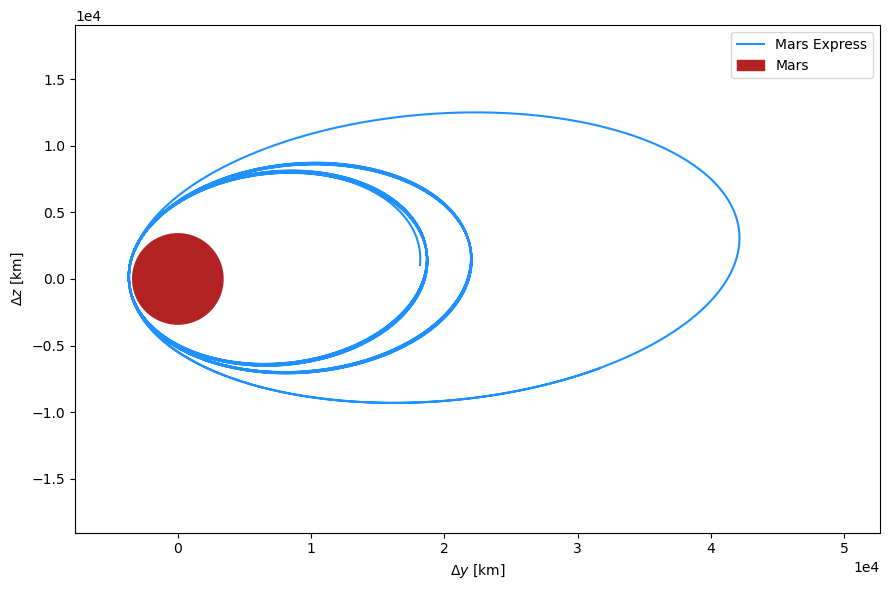

In [3]:
time2plt = np.arange(simulation_start_epoch, simulation_end_epoch, 60)
mex2plt = list()
for epoch in time2plt:
    mex2plt.append(spice.get_body_cartesian_position_at_epoch(
        target_body_name="MEX",
        observer_body_name="Mars",
        reference_frame_name="ECLIPJ2000",
        aberration_corrections="none",
        ephemeris_time=epoch))
mex2plt = np.array(mex2plt)
radius_mars = spice.get_average_radius("Mars")

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))
ax1.axis('equal')

ax1.plot(mex2plt[:, 1]*1E-3, mex2plt[:, 2]*1E-3, color="dodgerblue", label="Mars Express")
ax1.add_patch(plt.Circle((0, 0), radius_mars*1E-3, color="firebrick", label="Mars"))

ax1.set_xlabel(r'$\Delta y$ [km]')
ax1.set_ylabel(r'$\Delta z$ [km]')
ax1.set_xlim(-1.0E4, 5.5E4)
ax1.set_ylim(-2.0E4, 2.0E4)
ax1.ticklabel_format(style='sci', scilimits=(0, 0), axis='both')
ax1.legend()

plt.tight_layout()
plt.show()

## Set Up the Observations
Having set the underlying environment model of the simulated orbit, we can define the observational model. This entails the addition all required ground stations, the definition of the observation links and types, as well as the precise simulation settings.
### Add a ground station
Following its real-world counterpart, our simulated Mars Express spacecraft will also be tracked using ESA's New Norcia (NNO) ESTRACK ground station. Located in North-East Australia, it will be set up with an altitude of 252m, 31.0482°S, 116.191°E.

In [4]:
# Define the position of the New Norcia (NNO) ESTRACK Earth station
station_altitude = 252.0
new_norcia_latitude = np.deg2rad(-31.0482)
new_norcia_longitude = np.deg2rad(116.191)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "NNO",
    [station_altitude, new_norcia_latitude, new_norcia_longitude],
    element_conversion.geodetic_position_type)

### Define Observation Model Settings
Within this example - as it is common practice when tracking deep-space missions using the ESTRACK system - Mars Express will not be tracked using a set of one-way signal path, but a n-way one (realised as two-way link ends in this example). For our example at hand this means that the signal travels from Earth to the spacecraft where it gets re-transmitted and subsequently has to travel back to Earth where it is recorded and processed. In particular, we will model two-way range and range-rate (Doppler) observables.

Moreover, expanding upon the knowledge from the previous examples, we will introduce how to introduce the settings for the light time correction of the signal due to the relativistic effects of the Sun, as well as how to impose a constant bias on one of the two observables.

In [5]:
# Define the uplink link ends for one-way observable
one_way_nno_mex_link_ends = dict( )
one_way_nno_mex_link_ends[observation.transmitter] = observation.body_reference_point_link_end_id("Earth", "NNO")
one_way_nno_mex_link_ends[observation.receiver] = observation.body_origin_link_end_id("MEX")
one_way_nno_mex_link_definition = observation.LinkDefinition(one_way_nno_mex_link_ends)

# Define settings for light-time calculations
light_time_correction_settings = observation.first_order_relativistic_light_time_correction(["Sun"])

# Define settings for range bias
range_bias_settings = observation.absolute_bias([0.01])

# Create list of observation settings
observation_settings_list = list()
observation_settings_list.append(observation.one_way_range(
    one_way_nno_mex_link_definition,
    light_time_correction_settings = [light_time_correction_settings],
    bias_settings = range_bias_settings))
observation_settings_list.append(observation.one_way_doppler_instantaneous(
    one_way_nno_mex_link_definition,
    light_time_correction_settings = [light_time_correction_settings]))

### Define Observation Simulation Settings
Finally, for each above-defined observation model, we will define the noise of the observation-type and several, general viability criteria. We impose the spacecraft to be at a certain minimum angle (15 degrees) of elevation above the horizon as seen from the ground station, as well as introduce Mars as a body that can potentially occult the line-of-sight between Mars Express and New Norcia (i.e. when the spacecraft dives 'behind' Mars, we will not simulate any observations).

In [6]:
# Define observation simulation times for each link (separated by steps of one minute)
observation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 60.0)
observation_simulation_settings = list()

observation_simulation_settings.append(observation.tabulated_simulation_settings(
    observation.one_way_instantaneous_doppler_type,
    one_way_nno_mex_link_definition,
    observation_times))

observation_simulation_settings.append(observation.tabulated_simulation_settings(
    observation.one_way_range_type,
    one_way_nno_mex_link_definition,
    observation_times))

# Add noise levels of roughly 1.0E-3 [m/s] and add this as Gaussian noise to the observation
noise_level_doppler = 1.0E-3
observation.add_gaussian_noise_to_observable(
    observation_simulation_settings,
    noise_level_doppler,
    observation.one_way_instantaneous_doppler_type
)

noise_level_range = 1.0
observation.add_gaussian_noise_to_observable(
    observation_simulation_settings,
    noise_level_range,
    observation.one_way_range_type
)

# Create viability settings
viability_settings = [observation.elevation_angle_viability(["Earth", "NNO"], np.deg2rad(15)),
                      observation.body_occultation_viability(["NNO", "MEX"], "Mars")]
observation.add_viability_check_to_all(
    observation_simulation_settings,
    viability_settings
)

## Define the Dynamical Model(s)
Note that unlike it has usually been the case so far - be it with examples dealing with propagation or the prior estimation ones - we have always defined a mere single dynamical model. The modular structure of tudat, however, enables us to simulate the observations using a dynamical model that is (theoretically entirely) different from the one used to perform the estimation. Hence, we will now first define the model that will be used during the simulation of observations. In particular, we will consider:
* Gravitational acceleration using a spherical harmonic approximation up to 4th degree and order for Mars.
* Gravitational acceleration using a simple point mass model for:
    - Mars' two moons Phobos and Deimos
    - Earth
    - Jupiter
    - The Sun
* Radiation pressure experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

In [7]:
# Define the accelerations acting on Mars Express during the observation simulation
accelerations_settings_mars_express_simulation = dict(
    Mars=[
        propagation_setup.acceleration.spherical_harmonic_gravity(4, 4)
    ],
    Phobos=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Deimos=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Jupiter=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Sun=[
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.cannonball_radiation_pressure()
    ])

### Perform the observations simulation
However, following the known - trivial - estimation pipeline, the observations are simulated using the `simulation_observations()` function of the respective `Estimator` object. However, to avoid having to create two distinct estimators, we will manually implement a set of observation simulators upfront, before altering the dynamical model and creating the actual estimator.

The way custom-implemented observation simulators are implemented is that they do not propagate any bodies themselves but simulate the observations based on the (tabulated) ephemerides of all involved bodies. However, while this process is rather straightforward in its implementation, this also entails to first having to update the ephemeris of MEX such that it stems from the dynamical model of choice and not its `SPICE` kernel.

Having updated the tabulated ephemeris of Mars Express, one can create the required `observation simulator` object and finally simulate the observations according to the above-defined settings.

In [8]:
### Accelerations ###
# Create global accelerations dictionary
acceleration_settings_simulation = {"MEX": accelerations_settings_mars_express_simulation}
# Create acceleration models
acceleration_models_simulation = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings_simulation,
    bodies_to_propagate,
    central_bodies)

### Initial State ###
initial_state = spice.get_body_cartesian_state_at_epoch(
    target_body_name="MEX",
    observer_body_name="Mars",
    reference_frame_name="ECLIPJ2000",
    aberration_corrections="none",
    ephemeris_time=simulation_start_epoch)

### Integrator and Termination Settings ###
# Create integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60.0,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)
# Create termination settings
termination_settings = propagation_setup.propagator.time_termination(simulation_end_epoch)

### Propagator Settings ###
propagator_settings_simulation = propagation_setup.propagator. \
    translational(central_bodies=central_bodies,
                  acceleration_models=acceleration_models_simulation,
                  bodies_to_integrate=bodies_to_propagate,
                  initial_states=initial_state,
                  initial_time=simulation_start_epoch,
                  integrator_settings=integrator_settings,
                  termination_settings=termination_settings)
# Create or update the ephemeris of all propagated bodies (here: MEX) to match the propagated results
propagator_settings_simulation.processing_settings.set_integrated_result = True
# Run propagation
dynamics_simulator = create_dynamics_simulator(bodies, propagator_settings_simulation)
state_history_simulated_observations = dynamics_simulator.state_history

# Create observation simulators
observation_simulators = estimation_setup.create_observation_simulators(
    observation_settings_list, bodies)
# Get MEX simulated observations as ObservationCollection
mex_simulated_observations = estimation.simulate_observations(
    observation_simulation_settings,
    observation_simulators,
    bodies)

### Alter the Dynamical Model for Mars
We will now re-purpose the previously defined dynamical model of accelerations acting on `MEX` by altering the perceived gravitational acceleration of Mars onto the spacecraft. In particular, we will remove the gravitational pull of both of Mars' moons - Phobos and Deimos - from the acceleration settings of the spacecraft. All remaining settings, however, remain untouched.

In [9]:
# Copy and subsequently alter the accelerations acting on Mars Express used during the estimation
accelerations_settings_mars_express_estimation = accelerations_settings_mars_express_simulation
accelerations_settings_mars_express_estimation.pop('Phobos')
accelerations_settings_mars_express_estimation.pop('Deimos')

# Create updated global accelerations dictionary
acceleration_settings_estimation = {"MEX": accelerations_settings_mars_express_estimation}

# Create updated acceleration models
acceleration_models_estimation = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings_estimation,
    bodies_to_propagate,
    central_bodies)

# Create updated propagator settings
propagator_settings_estimation = propagation_setup.propagator. \
    translational(central_bodies=central_bodies,
                  acceleration_models=acceleration_models_estimation,
                  bodies_to_integrate=bodies_to_propagate,
                  initial_states=initial_state,
                  initial_time=simulation_start_epoch,
                  integrator_settings=integrator_settings,
                  termination_settings=termination_settings)

## Perform the estimation
Having altered the dynamical model as well as the propagator settings, we create the `Estimator` object and subsequently set up the inversion of the problem - in particular, one has to define which parameters are to be estimated, could potentially include any a-priori information in the form of an a-priori covariance matrix, and define the weights associated with the individual types of observations.

In [10]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings_estimation, bodies)

# Add estimated parameters to the sensitivity matrix that will be propagated
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Mars"))

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

# Create the estimator
estimator = numerical_simulation.Estimator(
    bodies,
    parameters_to_estimate,
    observation_settings_list,
    propagator_settings_estimation)

# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector

# Create input object for the estimation
estimation_input = estimation.EstimationInput(
    mex_simulated_observations)

# Set methodological options
estimation_input.define_estimation_settings(
    reintegrate_variational_equations=False,
    save_state_history_per_iteration=True)

# Define weighting of the observations in the inversion
weights_per_observable = {estimation_setup.observation.one_way_instantaneous_doppler_type: noise_level_doppler ** -2,
                          estimation_setup.observation.one_way_range_type: noise_level_range ** -2}
estimation_input.set_constant_weight_per_observable(weights_per_observable)

### Estimate the individual parameters
Finally, the actual estimation can be performed - ideally having reached a sufficient level of convergence, the least squares estimator will have found the most suitable parameters for the problem at hand.

In analogy to the prior examples we will again qualitatively compare the goodness-of-fit of the found parameters with the known ground truth ones. Realise that this is typically cannot be done when working with real-world observations since the ground truth is not known (and is exactly what one would like to know). However, since we conveniently know these parameters, it serves as a handy measure to shed light onto the estimation process. In particular, this highlights the fact that with increasing discrepancy between the dynamical models used within the simulation and estimation routines, the true-to-formal error ratio has to increase, since - besides to the pure estimation of parameters - the (artificially) introduced modelling imperfections have to be implicitly mitigated altering the values of the same set of parameters.

In [11]:
# Perform the covariance analysis
estimation_output = estimator.perform_estimation(estimation_input)

Calculating residuals and partials 10960
Parameter update    -19.4531      92.5107      87.1101 -3.74445e-05  0.000251501  -0.00313899  2.37492e+08
Current residual: 20.7963
Calculating residuals and partials 10960
Parameter update 0.00297709   -0.012585  -0.0237226 1.00659e-08 1.82672e-08 8.09463e-07    -34195.3
Current residual: 3.57751
Calculating residuals and partials 10960
Parameter update 1.65853e-05 -6.69606e-05 -0.000135326    1.576e-10 -6.96904e-10  3.67655e-09     -133.732
Current residual: 3.57753
Calculating residuals and partials 10960
Parameter update-1.70772e-05  7.15194e-05  9.68745e-05   7.6459e-12 -1.11272e-10 -3.27753e-09      196.657
Current residual: 3.57753
Calculating residuals and partials 10960
Parameter update 8.90933e-06 -2.94556e-05 -4.71532e-06 -1.89195e-10  9.75824e-10  8.76968e-10     -134.679
Current residual: 3.57753
Maximum number of iterations reached
Final residual: 3.57751


In [12]:
# Print the covariance matrix
print(estimation_output.formal_errors)
print(truth_parameters - parameters_to_estimate.parameter_vector)

[2.49263916e-01 9.96414150e-01 2.26329284e+00 6.24681254e-06
 2.72667190e-05 5.74299448e-05 3.22850631e+06]
[ 1.94501039e+01 -9.24980881e+01 -8.70863574e+01  3.74344732e-05
 -2.51519058e-04  3.13817993e-03 -2.37457542e+08]


## Post-processing
Finally, to further illustrate the impact certain differences between the applied dynamical models have, we will first plot the behaviour of the simulated observations over time, as well as show how the discrepancy between our estimated solution and the 'ground truth' builds up over time.

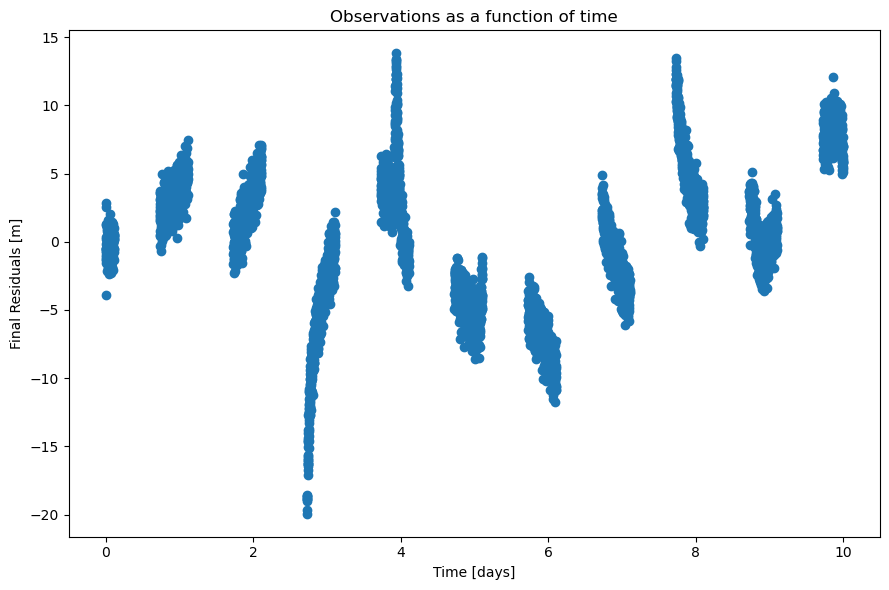

In [13]:
final_residuals = estimation_output.final_residuals
observation_times = np.array(mex_simulated_observations.concatenated_times)

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

ax1.scatter((observation_times[0:int(len(observation_times)/2)] - observation_times[0]) / (3600*24),
            final_residuals[0:int(len(final_residuals)/2)])

ax1.set_title("Observations as a function of time")
ax1.set_xlabel(r'Time [days]')
ax1.set_ylabel(r'Final Residuals [m]')
plt.tight_layout()
plt.show()

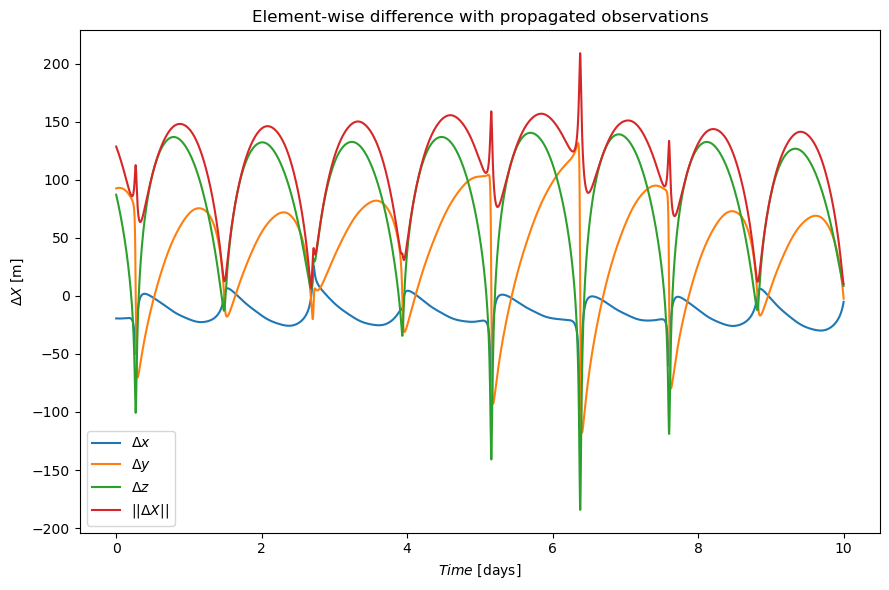

In [14]:
simulator_object = estimation_output.simulation_results_per_iteration[-1]
state_history = simulator_object.dynamics_results.state_history

time2plt = np.vstack(list(state_history.keys()))
time2plt_normalized = (time2plt - time2plt[0]) / (3600*24)

mex_prop = np.vstack(list(state_history.values()))
mex_sim_obs = np.vstack(list(state_history_simulated_observations.values()))

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))

ax1.plot(time2plt_normalized, (mex_prop[:, 0] - mex_sim_obs[:, 0]), label=r'$\Delta x$')
ax1.plot(time2plt_normalized, (mex_prop[:, 1] - mex_sim_obs[:, 1]), label=r'$\Delta y$')
ax1.plot(time2plt_normalized, (mex_prop[:, 2] - mex_sim_obs[:, 2]), label=r'$\Delta z$')
ax1.plot(time2plt_normalized, np.linalg.norm((mex_prop[:, 0:3] - mex_sim_obs[:, 0:3]), axis=1), label=r'$||\Delta X||$')

ax1.set_title("Element-wise difference between true and estimated states")
ax1.set_xlabel(r'$Time$ [days]')
ax1.set_ylabel(r'$\Delta X$ [m]')
ax1.legend()

plt.tight_layout()
plt.show()